The number of timesteps is 98


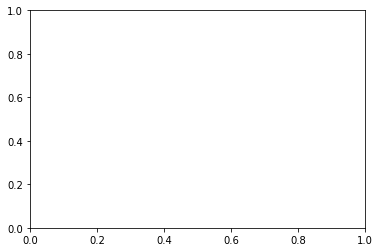

In [13]:
import pdb
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb

%matplotlib inline

DATA_FILE = "/home/david/dev/SmokeDetectorOptimization/exportUSLab.csv" # Points to the data Katie gave us
VISUALIZE = False
ALARM_THRESHOLD = 2e-21
BIG_NUMBER = 100

all_points = [[]] # This is a doubly-nested list with each internal list representing a single timestep

with open(DATA_FILE, 'r') as infile: # read through line by line and parse by the time
    for line in infile:
        if "symmetry" in line:
            all_points.append([line])
        all_points[-1].append(line)  
       
print("The number of timesteps is {}".format(len(all_points)))

plt.cla()

all_times = []
max_consentrations = []
for time in all_points[1:-1]: #only do a few at the end for speed reasons
    df = pd.read_csv(io.StringIO('\n'.join(time[4:])))#
    df = df.rename(columns={'Node Number': 'N',
                  ' X [ m ]' : 'X',
                  ' Y [ m ]' : 'Y',
                  ' Z [ m ]' : 'Z',
                  ' Particle Mass Concentration [ kg m^-3 ]' : 'C'})
    all_times.append(df)
    consentration = df['C'].values[0:-1] # get all of the consentrations but the null last one
    max_consentrations.append(np.max(consentration))

if VISUALIZE:
    print(max_consentrations)
    max_consentration = max(max_consentrations)
    print(max_consentration)
    
    for i, df in enumerate(all_times): 
    
        plt.cla()
        plt.clf()
        plt.xlabel("X position")
        plt.ylabel("Y position")
        plt.title("consentration at timestep {} versus position".format(i))
        norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
        cb = plt.scatter(df['X'], df['Y'], c=df['C'] / max_consentration, cmap=plt.cm.inferno, norm=norm)
        plt.colorbar(cb) # Add a colorbar to a plot
        plt.savefig("vis/consentration{:03d}.png".format(i))

So the next thing we want to do is convert the output to a 2d space

There are 96 timesteps and 2666 flattened locations


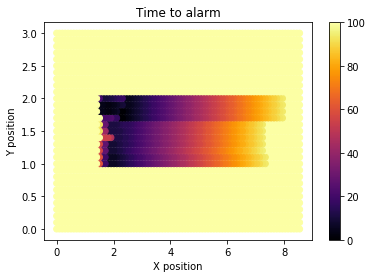

In [17]:
consentrations = np.asarray([x['C'].values[:-1] for x in all_times]) # Get all of the consentrations 
print("There are {} timesteps and {} flattened locations".format(consentrations.shape[0], consentrations.shape[1])) 

alarmed = consentrations > ALARM_THRESHOLD
nonzero = np.nonzero(alarmed)
nonzero_times, nonzero_locations = nonzero # this is pairs indicating that it alarmed at that time and location

time_to_alarm = []
for loc in range(alarmed.shape[1] + 1): # All of the possible locations
    same = loc == nonzero_locations
    if(np.any(same)):
        alarmed_times = nonzero_times[same]
        #print("alarmed times {} at location {}".format(alarmed_times, loc))
        #print("first alarmed times is {} at location {}".format(min(alarmed_times), loc))
        time_to_alarm.append(min(alarmed_times))
    else:
        time_to_alarm.append(BIG_NUMBER)
        

#print(time_to_alarm)

plt.cla()
plt.clf()
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Time to alarm")
norm = mpl.colors.Normalize(vmin=0, vmax=BIG_NUMBER)
cb = plt.scatter(df['X'], df['Y'], c=time_to_alarm, cmap=plt.cm.inferno, norm=norm)
plt.colorbar(cb) # Add a colorbar to a plot

In [5]:
#
def make_lookup(data_frame):
    """Returns a function which searches 
    the data at the sample nearest a given point
    """
    X = data_frame['X'].values[0:-1]
    Y = data_frame['Y'].values[0:-1]
    C = data_frame['C'].values[0:-1]
    best = np.argmax(C)
    XY = np.vstack((X,Y)).transpose()
    print(XY[best,:])
    def ret_func(xy):
        diff = xy - XY
        dist = np.linalg.norm(diff, axis=1)
        loc = np.argmin(dist)
        closest_c = C[loc]
        return closest_c
    return ret_func
ret_func = make_lookup(df)

print(ret_func(np.array([3.61694121, 1.29999995])))

[3.61694121 1.29999995]
9.953158640000001e-20


In [3]:
from scipy.optimize import minimize, rosen, rosen_der

BOUNDS = (0.2, 2.0) # constraints on inputs
INIT = (4,2)
res = minimize(ret_func, INIT, method='SLSQP', bounds=((0,8),(0, 3)))
print(res)


NameError: name 'ret_func' is not defined